#### In this program, I will analysis two output files from the simulation 
#### 1) 'out.txt' from bernoulli distribution with bernoulli outcomes of 0 or 1
#### 2) 'stb.txt' with probability of success for each trail

In this simulation, each experiment will contain Nmea independent bernoulli trails, each have probability of success (stable) as $p_{stable}$; The likelihood for $p_{stable}$ based on X is defined as the joint probability distribution of 

$L(p;x)\approx f(x;p)=\prod\limits_{i=1}^n f(x_i;p)=\prod\limits_{i=1}^n p^x(1-p)^{1-x}$

Differentiating the $\log L(p ; x)$

$LL(p;x) = \prod\limits_{i=1}^n \log p^{x_{i}}(1-p)^{1-x_{i}}
         = \prod\limits_{i=1}^n x_{i} (\log p) + (1-x_{i})\log(1-p)
         = Y\log p +(n-Y)\log(1-p)$ where $Y = \sum\limits_{i=1}^n x_i $

To find the value which maximizes a function that is to find the first derivative of the function and set it equal to 0. 


However, in our simulation, $P_{stable}$ for each trail is calculated numerically from samples from beta distribution of different value of $\alpha$, thus we would want to relate $\alpha$ numerically to $P(P_{stable};\alpha)$ which can be observed from histogram of $P_{stable}$

In [1]:
# imports of external packages to use in our code
import sys
import math
import random
import numpy as np
import scipy.interpolate
import scipy.optimize as optimize
from scipy.optimize import minimize
from scipy.optimize import least_squares
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
from scipy.optimize import curve_fit
import lmfit

# global parameters needed

# defalut number of samples per measurement 
Nsamples = 100  

# default number of measurements per experiment
Nmeas = 100  

# default number of experiments
Nexp = 1000

# alpha value
a = np.linspace(0, 1, Nexp)

# fixed beta
b = 2.0   

# fixed Mass fraction in the calculation of Delta_cr
M = 10 

### Analysis of simulated data 

In [2]:
# Load the Pstable outputfile as Input  
data_stb = np.loadtxt('out_t.txt')

### Analysis of 'out.txt' :  $x_{i} = 0$ or $x_{i} = 1$
### Numericaly count stable outcome per experiment as measurement of Pstable

In [13]:
# load the data 
data_out = np.loadtxt('out.txt')

In [14]:
# count how much stable outcome in each experiment and return probability of being stable/ per experiment
def get_prob(InputFile):
    # read input file
    with open(InputFile) as ifile:
        ct=[]
        for line in ifile:
            lineVals = line.split()
            Nmea = len(lineVals)
            count = 0
            i = 0
            while i in range(Nmea):
                if lineVals[i] == '1':
                    count = count +1
                i = i +1
            ct.append(count)
        
        prob = []
        for c in ct:
            p = c /(len(lineVals))
            prob.append(p)
        # count how much stable outcome in each experiment and return probability of being stable/ per experiment
        return prob, ct

# This is the probability of getting stable outcome for every experiment
Pstable = get_prob('out.txt')[0]
counts = get_prob('out.txt')[1]

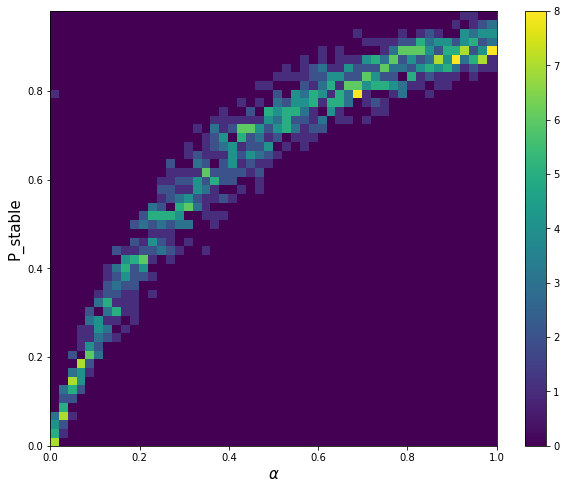

In [15]:
# 2d histogram of Pstable and different range of alpha
a = np.linspace(0, 1, Nexp)
plt.figure(figsize=(10,8))
bin_x = plt.hist2d(a, Pstable, bins=[50,50])[1]
bin_y = plt.hist2d(a, Pstable, bins=[50,50])[2]
#print(np.diff(bin_x))
#print(np.diff(bin_y))
plt.colorbar()
plt.ylabel('P_stable', fontsize = 15)
plt.xlabel('$\\alpha$ ',fontsize = 15)
plt.savefig('Neyman_pstable.pdf')
plt.show()

### Define likelihood function!
$L(p;x)\approx f(x;p)=\prod\limits_{i=1}^n f(x_i;p)=\prod\limits_{i=1}^n p^x(1-p)^{1-x}$

Differentiating the $\log L(p ; x)$

$LL(p;x) = \prod\limits_{i=1}^n \log p^{x_{i}}(1-p)^{1-x_{i}}
         = \prod\limits_{i=1}^n x_{i} (\log p) + (1-x_{i})\log(1-p)
         = Y\log p +(n-Y)\log(1-p)$ where $Y = \sum\limits_{i=1}^n x_i $
         
         
#### Setting the derivative to zero shows that this function achieves a maximum at $\hat{p}=\sum\limits_{i=1}^n x_i/n$. Since $\sum\limits_{i=1}^n x_i$ is the total number of successes observed in the n trials,  is the observed proportion of successes in the n trials.

In [16]:
def LL(p):
    for i in counts:
        return -(i *np.log(p) + (Nmea - i)* np.log(1-p))

# 0.7
# calculate the P estimates for each experiment
p_ests = []
p_est_errs = []
for e in range(Nexp):
    # initial guess
    p0 = 0.5
    # do the minimization
    res =  least_squares(LL, p0)
    
    p_est = res.x[0]
    p_est_err = res.jac[0][0]

    p_ests.append(p_est)
    p_est_errs.append(p_est_err)


<ipython-input-16-8fd944e7de91>:3: RuntimeWarning: divide by zero encountered in log
  return -(i *np.log(p) + (Nmea - i)* np.log(1-p))


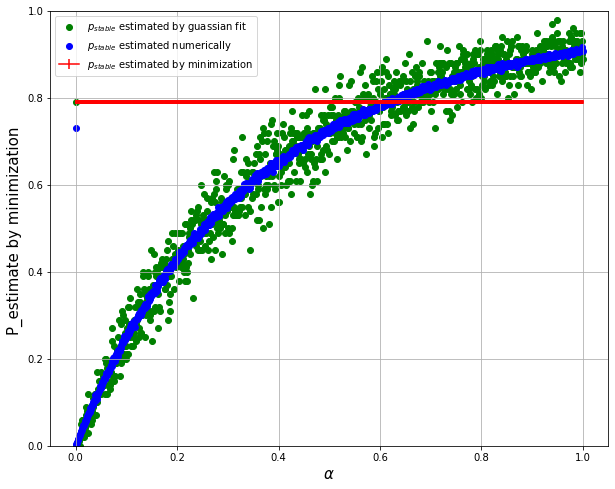

In [17]:
# 2d histogram of Pstable and different range of alpha
a = np.linspace(0, 1, Nexp)
plt.figure(figsize=(10,8))
plt.errorbar(a, p_ests, yerr = p_est_errs, color= 'r', label = '$p_{stable}$ estimated by minimization')
plt.scatter(a, Pstable, color = 'g', label = '$p_{stable}$ estimated by guassian fit')
plt.scatter(a, pprob, color = 'b', label = '$p_{stable}$ estimated numerically')
#bin_x = plt.hist2d(a, p_ests, bins=[50,50])[1]
#bin_y = plt.hist2d(a, p_ests, bins=[50,50])[2]
#print(np.diff(bin_x))
#print(np.diff(bin_y))
#plt.colorbar()
plt.grid()
plt.ylim(0,1)
plt.ylabel('P_estimate by minimization ', fontsize = 15)
plt.xlabel('$\\alpha$ ',fontsize = 15)
plt.legend()
plt.savefig('comparison.pdf')
plt.show()